In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class World(object):

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.R = np.zeros(self.x*self.y)
        self.agentPos = 0
        self.grid = np.zeros((self.x, self.y))  # Adding the grid so we can visualize the environment later
        self.goalState = None  # Goal state will be set when calling setReward()
        self.fearState= None

    def xy2idx(self,x,y): # transfering the location to a unique id representing the current state
        return x*self.y + y

    def idx2xy(self,idx):
        # To do
        # Based on idx that we have, how we can retrieve x, y?
        # 把线性索引转换回 (x, y) 与 xy2idx 保持一致：idx = x*self.y + y
        x = int(idx // self.y)
        y = int(idx % self.y)
        return x, y
        

    def resetAgent(self, pos):
        self.agentPos = int(pos)

    def setReward(self, x, y, r):
        # get the goal state location, and assigne a reward to that cell
        goalState = self.xy2idx(x, y)
        self.R[goalState] = r
        if r> 0:
            self.goalState = (x, y)  # Store goal state as a tuple (x, y)
        else:
            self.fearState= (x,y)

    def getState(self):
        return self.agentPos

    def getReward(self):
        return self.R[self.agentPos]

    def getNumOfStates(self):
        return self.x*self.y

    def getNumOfActions(self):
        return 4

    def move(self, id):
        """根据动作 id 改变 agentPos（0: Down, 1: Up, 2: Right, 3: Left）"""
        x_, y_ = self.idx2xy(self.agentPos)
        tmpX = x_
        tmpY = y_

        if id == 0:       # Down (x + 1)
            tmpX += 1
        elif id == 1:     # Up (x - 1)
            tmpX -= 1
        elif id == 2:     # Right (y + 1)
            tmpY += 1
        elif id == 3:     # Left (y - 1)
            tmpY -= 1
        else:
            raise ValueError(f"Unknown action id: {id}")

        if self.validMove(tmpX, tmpY):
            self.agentPos = self.xy2idx(tmpX, tmpY)
        # 如果不是 valid move，就保持原地不动

    def validMove(self, x, y):
        if x < 0 or x >= self.x or y < 0 or y >= self.y:
            return False
        return True


    def display(self):
        fig, ax = plt.subplots()
    
        ax.set_facecolor('white')
        
        ax.imshow(self.grid, cmap="viridis", origin="upper", extent=(0, self.y, 0, self.x), alpha=0)
        agent_x, agent_y = self.idx2xy(self.agentPos)  
        agent_circle = plt.Circle((agent_y + 0.5, self.x - agent_x - 0.5), 0.3, color='grey', ec='black') 
        ax.add_patch(agent_circle) 
    

        if hasattr(self, 'goalState'):
            goal_x, goal_y = self.goalState 
            goal_circle = plt.Circle((goal_y + 0.5, self.x - goal_x - 0.5), 0.3, color='green', ec='black') 
            ax.add_patch(goal_circle)  
    
 
        if self.fearState != None:
            if hasattr(self, 'fearState'):
                fear_x, fear_y = self.fearState  
                fear_circle = plt.Circle((fear_y + 0.5, self.x - fear_x - 0.5), 0.3, color='red', ec='black')  
                ax.add_patch(fear_circle) 
        
        ax.set_xticks(np.arange(self.y))
        ax.set_yticks(np.arange(self.x))
        ax.set_xticklabels(np.arange(self.y))
        ax.set_yticklabels(np.arange(self.x)[::-1])
        ax.grid(which="both", color="black", linestyle="-", linewidth=1)
    
        plt.show()

state num =  5
state loc =  (1, 1)


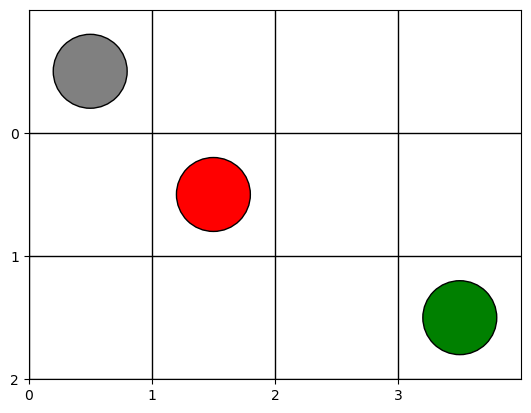

In [3]:
world = World(3,4)
world.setReward(2, 3, 1.0) #Goal state
world.setReward(1, 1, -1.0) #Fear region
print("state num = ",world.xy2idx(1,1))
print("state loc = ",world.idx2xy(5))
world.display()


In [ ]:
class Agent_SARSA(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.random.uniform(0.0,0.01,(self.numOfStates,self.numOfActions))
        self.alpha = 0.7
        self.gamma = 0.4
        self.epsilon = 0.25

    # epsilon-greedy action selection
    def actionSelection(self, state):
        # 随机探索
        if np.random.rand() < self.epsilon:
            return int(np.random.randint(0, self.numOfActions))
        # 利用：选取 Q 最大的动作（若并列，随机选一个）
        qvals = self.Q[state, :]
        max_q = np.max(qvals)
        candidates = np.where(qvals == max_q)[0]
        return int(np.random.choice(candidates))

    def train(self, iter):
        for itr in range(iter):

            state = int(np.random.randint(0,self.numOfStates))
            self.world.resetAgent(state)

            # choose action
            a = self.actionSelection(state)
            expisode = True

            while expisode:
                # perform action
                self.world.move(a)
                # look for reward
                reward = self.world.getReward()
                state_new = int(self.world.getState())
                # new action
                a_new = self.actionSelection(state_new)

                # SARSA 更新：Q(s,a) <- Q(s,a) + alpha * (r + gamma * Q(s',a') - Q(s,a))
                self.Q[state, a] += self.alpha * (reward + self.gamma * self.Q[state_new, a_new] - self.Q[state, a])

                # 如果到达终点（这里用 reward == 1.0 判定 goal），将 goal 状态的 Q 行清零并结束 episode
                if reward == 1.0:
                    self.Q[state_new, :] = 0
                    expisode = False
                else:
                    # 否则继续：s <- s', a <- a'
                    state = state_new
                    a = a_new

        print(self.Q)
        return self.Q

    def plotQValues(self):
        plt.rcParams.update({'font.size': 18})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()


[[-0.26436712 -0.00389569 -0.00107876 -0.00328175]
 [-0.9506274   0.01283867  0.05382082  0.00282295]
 [ 0.06711103  0.03884303  0.05371871  0.00207923]
 [ 0.39993174  0.02048725  0.03058129  0.02790405]
 [-0.04304779 -0.00363949 -0.93954107 -0.03316358]
 [ 0.04872735  0.01235968 -0.22107139  0.02163435]
 [ 0.04339819  0.02381511  0.29480472 -0.96070232]
 [ 1.00000005  0.12516132  0.0997882   0.10397367]
 [-0.02062879 -0.10230813 -0.3111255  -0.02348358]
 [ 0.03411416 -0.96054947  0.29926032  0.01020939]
 [ 0.29304906  0.04994704  1.         -0.2588264 ]
 [ 0.          0.          0.          0.        ]]


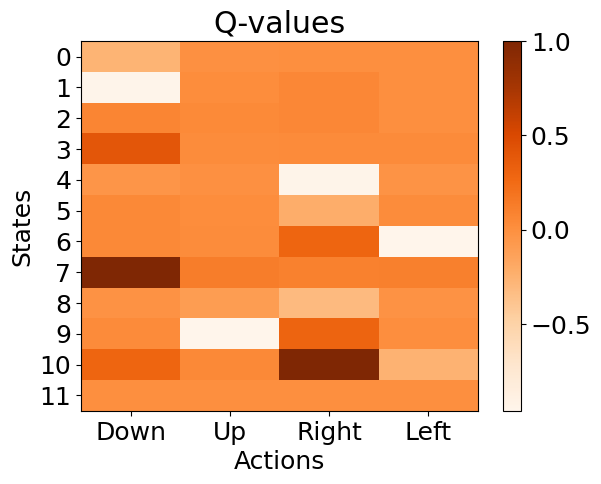

In [5]:
#Section 3.a.
world = World(3,4)

#Section 3.b.
world.setReward(2, 3, 1.0) #Goal state
world.setReward(1, 1, -1.0) #Fear region

#Section 3.c.
learner_SARSA = Agent_SARSA(world)

#Section 3.d.
learner_SARSA.train(1000)

#Section 3.e.
learner_SARSA.plotQValues()

In [8]:
def show_path(agent, world):
    done = True
    steps = 0

    # Start with a random state
    state = int(np.random.randint(0, agent.numOfStates))
    world.resetAgent(state)

    while done:
        world.display() 
        
        #To do
        # Choose the action based on the Q-table
        # 依据 agent 的 policy 在当前 state 选择动作（不改变 epsilon）
        action = np.argmax(agent.Q[state,:])
        
        print('Action taken:',action)
        print('Q-table values for all actions in the state:',agent.Q[state, :])
        world.move(action)

        # Get reward and new state
        reward = world.getReward()
        state = int(world.getState())
        steps += 1

        # Check if the episode is done
        if reward == 1.0:
            done = False

    world.display()  
    # Final visualization

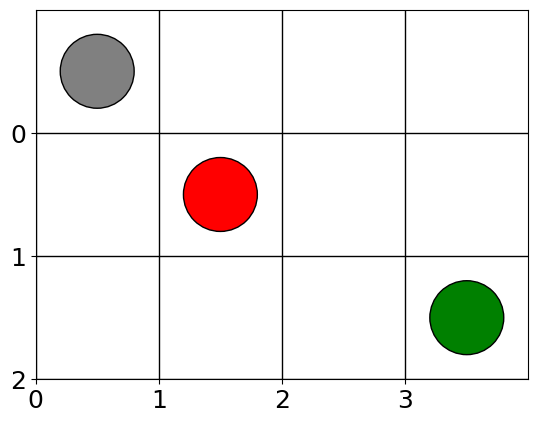

Action taken: 2
Q-table values for all actions in the state: [-0.26436712 -0.00389569 -0.00107876 -0.00328175]


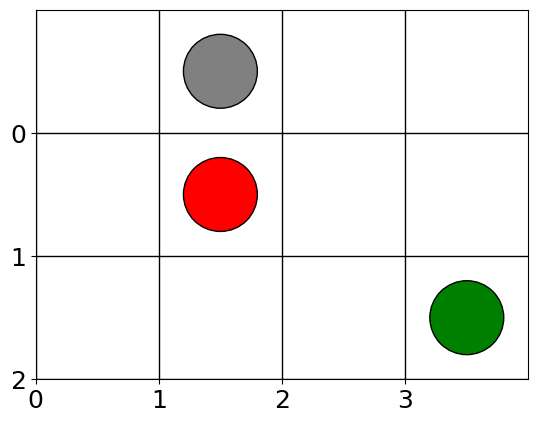

Action taken: 2
Q-table values for all actions in the state: [-0.9506274   0.01283867  0.05382082  0.00282295]


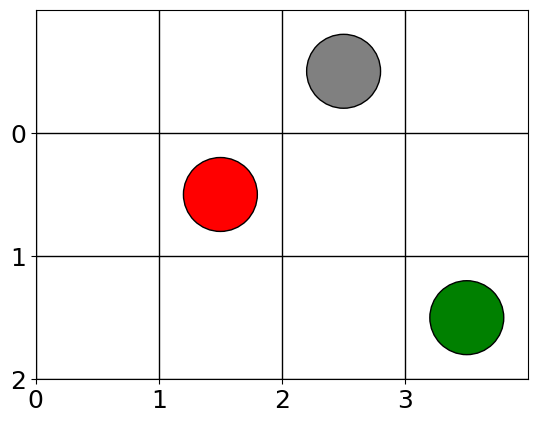

Action taken: 0
Q-table values for all actions in the state: [0.06711103 0.03884303 0.05371871 0.00207923]


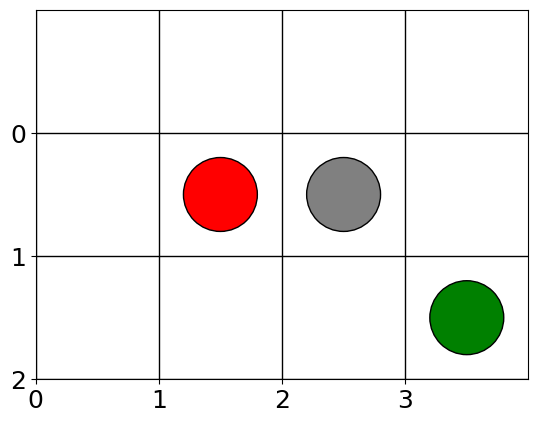

Action taken: 2
Q-table values for all actions in the state: [ 0.04339819  0.02381511  0.29480472 -0.96070232]


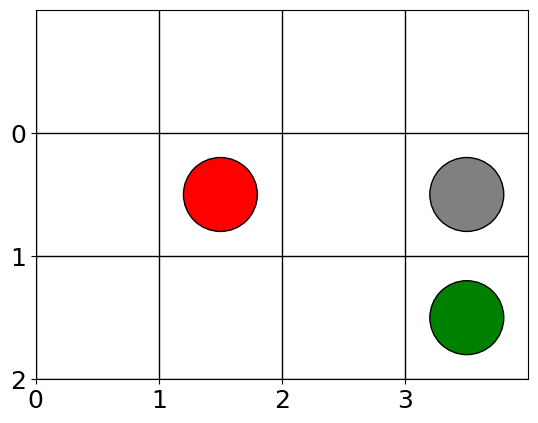

Action taken: 0
Q-table values for all actions in the state: [1.00000005 0.12516132 0.0997882  0.10397367]


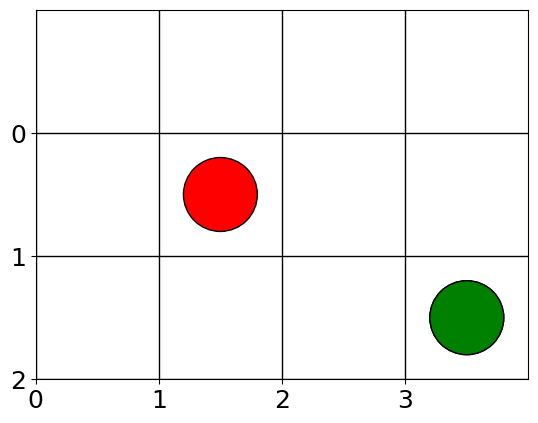

In [9]:
show_path(learner_SARSA, world)

In [ ]:
class Agent_Q_learning(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.random.uniform(0.0, 0.01, (self.numOfStates, self.numOfActions))
        self.alpha = 0.7
        self.gamma = 0.4
        self.epsilon = 0.25

    # epsilon-greedy action selection
    def actionSelection(self, state):
         # To do
        # Add the algorithm that the agent choose an action based on that
        if np.random.rand() < self.epsilon:
            return int(np.random.randint(0, self.numOfActions))
        qvals = self.Q[state, :]
        max_q = np.max(qvals)
        action = np.where(qvals == max_q)[0]    
        return action

    def train(self, iter):
        for itr in range(iter):
            state = int(np.random.randint(0, self.numOfStates))
            self.world.resetAgent(state)

            expisode = True

            while expisode:
                # choose action
                a = self.actionSelection(state)

                # perform action
                self.world.move(a)

                # look for reward
                reward = self.world.getReward()
                state_new = int(self.world.getState())
                
                #To do
                # update Q-values (using max Q-value for next state)
                # Q-learning 更新：Q(s,a) += alpha * (r + gamma * max_a' Q(s',a') - Q(s,a))
                self.Q[state, a] += self.alpha * (reward + self.gamma * np.max(self.Q[state_new, :]) - self.Q[state, a])

                if reward == 1.0:
                    self.Q[state_new,:] = 0
                    expisode = False

        print(self.Q)
        return self.Q

    def plotQValues(self):
        plt.rcParams.update({'font.size': 18})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()


In [ ]:

world = World(3,4)

#Section 3.b.
world.setReward(2, 3, 1.0) #Goal state
world.setReward(1, 1, -1.0) #Fear region

#Section 3.c.
learner_Q_learning = Agent_Q_learning(world)

#Section 3.d.
learner_Q_learning.train(1000)

#Section 3.e.
learner_Q_learning.plotQValues()

In [ ]:
show_path(learner_Q_learning , world)